In [1]:
import pandas as pd
df = pd.read_csv("health.csv")
df0 = pd.get_dummies(df, columns=["operating_condition"])

In [2]:
df = df0.drop("timestamp", axis=1)

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
X = df.drop(['cycle_id', 'health', "timestamp"], axis=1)
y = df['health']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cols_to_scale = ['step_in_cycle', 'vibration_rms', 'temperature', 'pressure', 'rotational_speed', 'current']
other_cols = [col for col in X.columns if col not in cols_to_scale]

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[cols_to_scale])
X_train_final = np.hstack((X_train_scaled, X_train[other_cols].values))

X_test_scaled = scaler.transform(X_test[cols_to_scale])
X_test_final = np.hstack((X_test_scaled, X_test[other_cols].values))


In [7]:
feature_names = cols_to_scale + other_cols
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_final.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae', 'mse'])
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,649 (45.50 KB)

 Trainable params: 11,649 (45.50 KB)

 Non-trainable params: 0 (0.00 B)

None


In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_final, y_train, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

Epoch 1/5
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 9.2080e-04 - mae: 0.0091 - mse: 9.2080e-04 - val_loss: 8.9494e-04 - val_mae: 0.0074 - val_mse: 8.9494e-04
Epoch 2/5
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 8.8722e-04 - mae: 0.0090 - mse: 8.8722e-04 - val_loss: 8.7203e-04 - val_mae: 0.0098 - val_mse: 8.7203e-04
Epoch 3/5
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 8.8260e-04 - mae: 0.0089 - mse: 8.8260e-04 - val_loss: 7.9905e-04 - val_mae: 0.0070 - val_mse: 7.9905e-04
Epoch 4/5
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 8.6782e-04 - mae: 0.0087 - mse: 8.6782e-04 - val_loss: 8.0434e-04 - val_mae: 0.0073 - val_mse: 8.0434e-04
Epoch 5/5
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 8.0443e-04 - mae: 0.0085 - mse: 8.0443e-04 - val_loss: 9.0290e-04 - val_mae: 0.0092 - val_mse: 9.0290e-04


In [10]:
y_pred = model.predict(X_test_final).flatten()

1117/1117 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [11]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Mean Absolute Error (MAE): 0.0069
Mean Squared Error (MSE): 0.0008
R-squared (R2): 0.9746


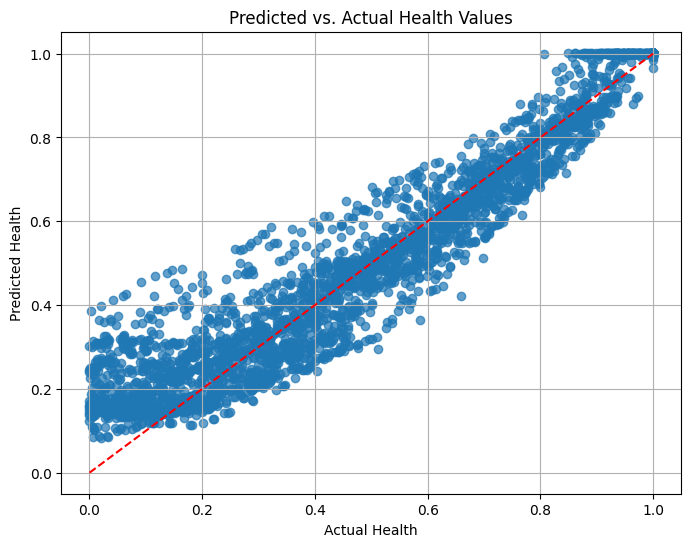

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.title('Predicted vs. Actual Health Values')
plt.xlabel('Actual Health')
plt.ylabel('Predicted Health')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid(True)
plt.show()

                           Feature  Importance
1                    vibration_rms    0.261263
6    operating_condition_High Load    0.200882
7     operating_condition_Low Load    0.178536
8  operating_condition_Medium Load    0.143128
5                          current    0.125880
3                         pressure    0.118947
2                      temperature    0.114116
0                    step_in_cycle    0.108372
4                 rotational_speed    0.105448


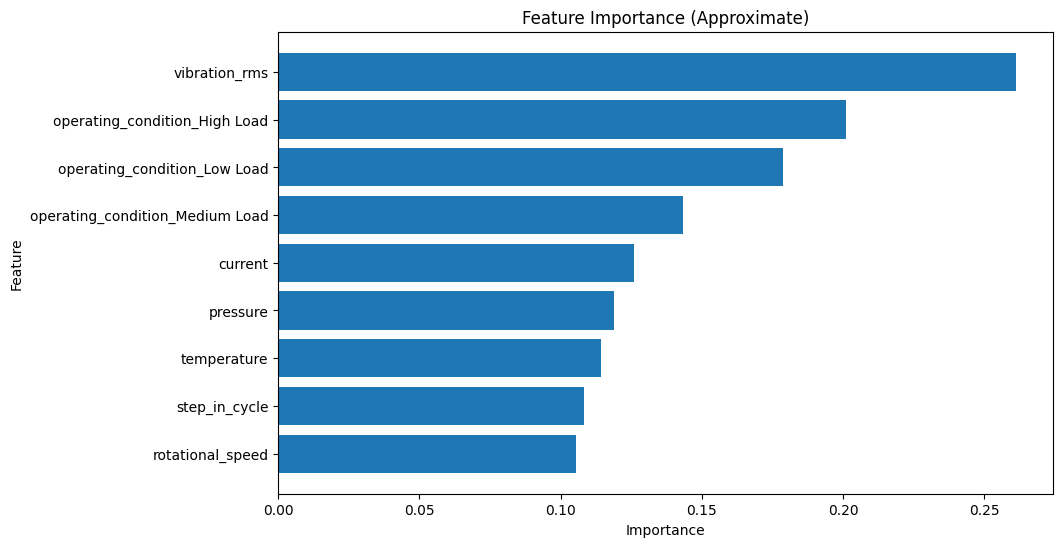

In [15]:
first_layer_weights = model.layers[0].get_weights()[0]
feature_importance = np.mean(np.abs(first_layer_weights), axis=1)


importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)


print(importance_df)


plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Approximate)')
plt.gca().invert_yaxis()
plt.show()


In [16]:
X

,step_in_cycle,vibration_rms,temperature,pressure,rotational_speed,current,operating_condition_High Load,operating_condition_Low Load,operating_condition_Medium Load
0,0,0.478520,32.717093,96.000635,1478.823692,9.538480,False,False,True
1,1,0.453874,32.570013,96.028997,1476.187166,9.717718,False,False,True
2,2,0.455290,32.550459,94.319082,1485.538496,9.632907,False,False,True
3,3,0.474627,33.063389,95.957370,1481.088999,9.622405,False,False,True
4,4,0.468561,32.854696,96.683650,1488.265941,9.866383,False,False,True
...,...,...,...,...,...,...,...,...,...
178709,4152,6.729385,176.886551,50.726536,1465.214334,40.066350,False,False,True
178710,4153,6.756981,177.921155,51.294744,1473.195057,40.343990,False,False,True
178711,4154,6.780502,179.158151,50.306993,1482.634849,40.307087,False,False,True
178712,4155,6.874316,180.816133,49.177673,1469.716925,40.664299,False,False,True


In [17]:
import joblib

In [18]:
joblib.dump(model, "welding-model.joblib")
joblib.dump(scaler, "welding-scaler.joblib")

['welding-scaler.joblib']

In [19]:
joblib.dump(y_test, "y_test_welding.joblib")
joblib.dump(X_test, "X_test_welding.joblib")

['X_test_welding.joblib']